In [9]:
### Questions ###
#1 Which genres perform best in Singapore/Asia?
#2 How has Asian content trended over time?
#3 Do ratings correlate with duration/type?

In [10]:
# Import Libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [11]:
## Load the data
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [12]:
## Check Missing Values
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [13]:
## Data Cleaning
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

df.dropna(subset=['date_added', 'country', 'rating', 'listed_in'], inplace=True)

df['year_added'] = df['date_added'].dt.year #Extract just the year

df['decade'] = (df['release_year'] // 10) * 10

df['is_asian'] = df['country'].str.contains('Singapore|Korea|Japan|Thailand|Indonesia|Malaysia|Philippines|Vietnam|Asia', case=False, na=False)

df['duration_minutes'] = (
    df['duration']
    .str.extract(r'(\d+)')
    .astype(float)
)

In [14]:
## SQLite in-memory
conn = sqlite3.connect(':memory:')
df.to_sql('netflix', conn, index=False)

## Run SQL
def run_sql(sql):
    return pd.read_sql(sql, conn)

## SQL Analyses
queries = {
    "top_countries": """
        SELECT country, COUNT(*) AS count
        FROM netflix
        GROUP BY country
        ORDER BY count DESC
        LIMIT 10;
    """,

    "yearly_trends": """
        SELECT year_added, type, COUNT(*) AS count
        FROM netflix
        GROUP BY year_added, type
        ORDER BY year_added;
    """,

    "genre_popularity": """
        SELECT listed_in, COUNT(*) AS count
        FROM netflix
        GROUP BY listed_in
        ORDER BY count DESC
        LIMIT 15;
    """,

    "asian_vs_global": """
        SELECT is_asian, type,
               AVG(duration_minutes) AS avg_duration,
               AVG(CASE WHEN rating IN ('TV-MA', 'R', 'NC-17') THEN 1 ELSE 0 END) AS mature_ratio
        FROM netflix
        GROUP BY is_asian, type;
    """,

    "top_asian_genres": """
        SELECT listed_in, COUNT(*) AS count
        FROM netflix
        WHERE is_asian = 1
        GROUP BY listed_in
        ORDER BY count DESC
        LIMIT 10;
    """
}

In [15]:
## Run queries
top_countries    = run_sql(queries['top_countries'])
yearly_trends    = run_sql(queries['yearly_trends'])
genre_popularity = run_sql(queries['genre_popularity'])
asian_vs_global  = run_sql(queries['asian_vs_global'])
top_asian_genres = run_sql(queries['top_asian_genres'])

/var/folders/mc/2p2n09dn13n8ynsjt2bw1ksc0000gn/T/ipykernel_53064/4143198453.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_asian_genres, x='count', y='listed_in', palette='magma')


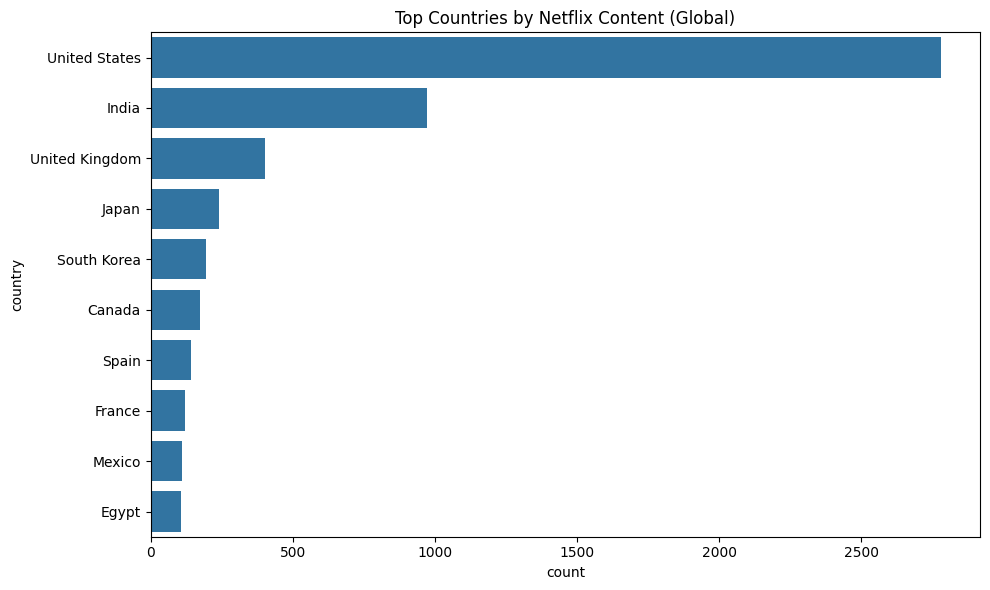

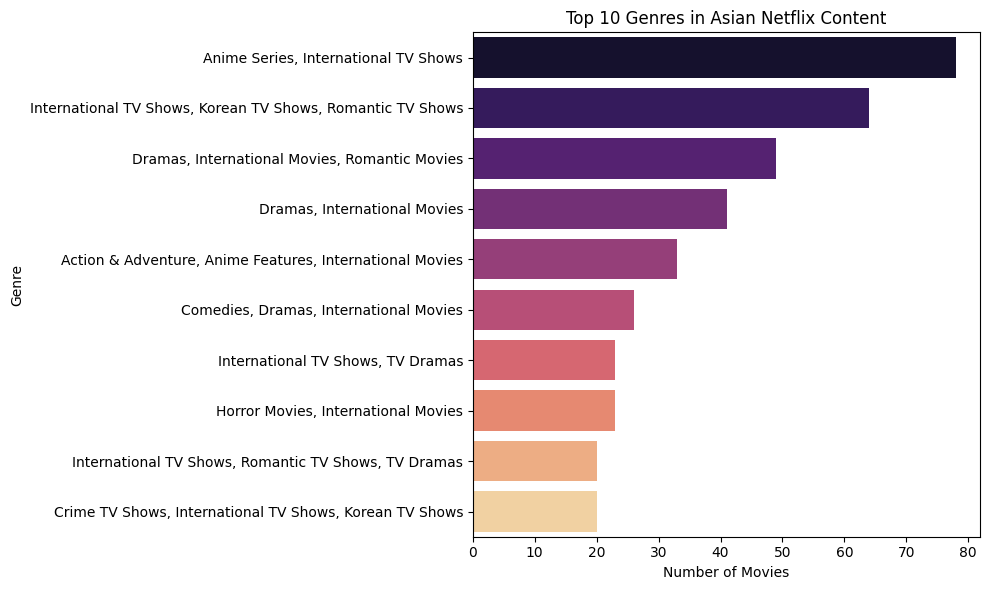

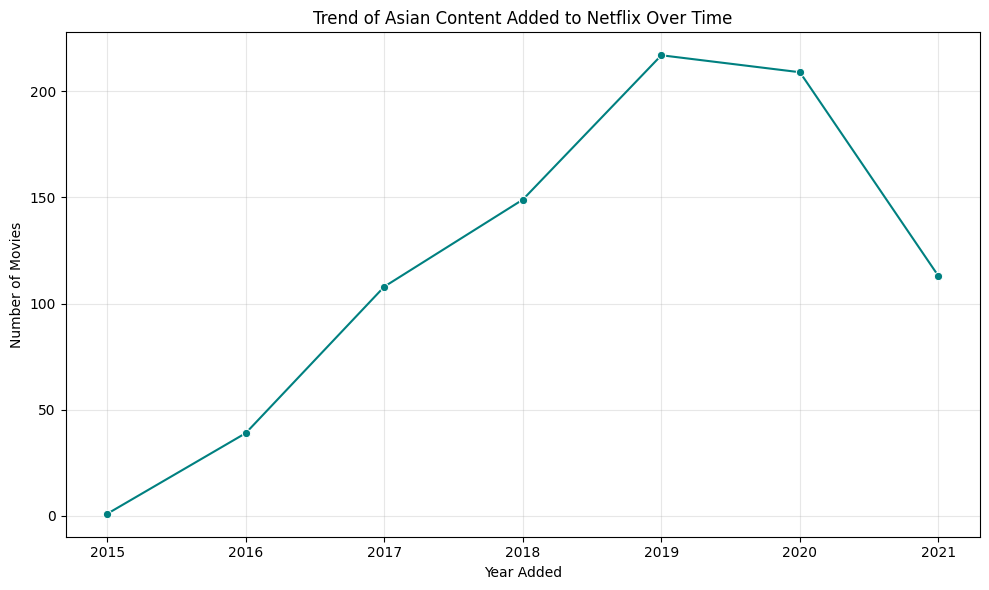

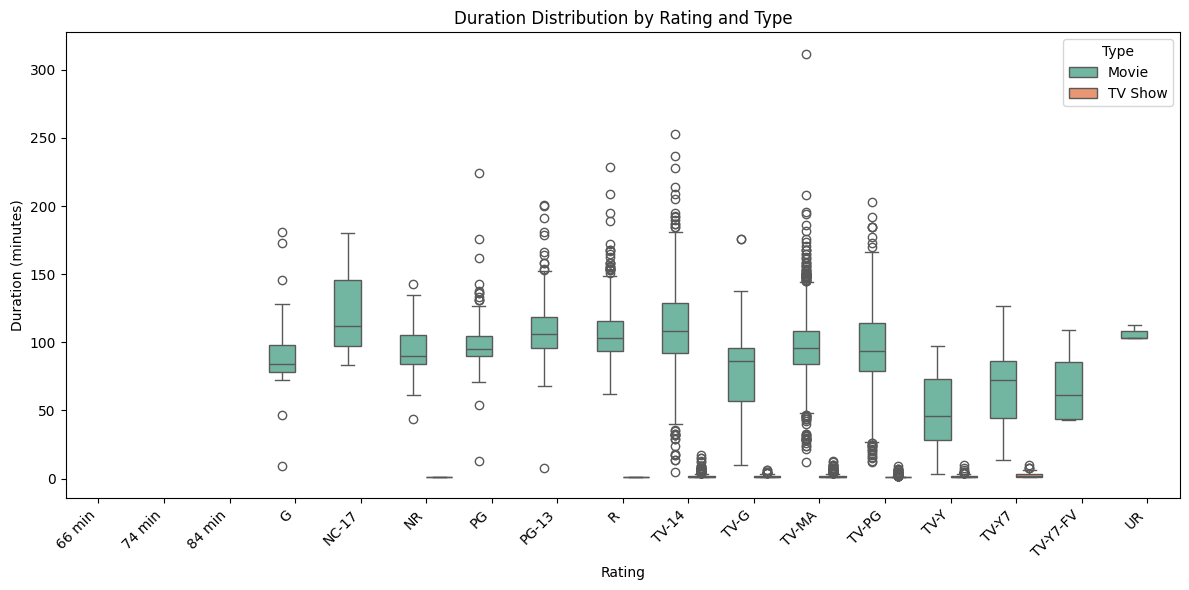

In [21]:
## Visualize
plt.figure(figsize=(10,6))
sns.barplot(data=top_countries, x='count', y='country')
plt.title('Top Countries by Netflix Content (Global)')
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_asian_genres, x='count', y='listed_in', palette='magma')
plt.title('Top 10 Genres in Asian Netflix Content')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()

asian_yearly = df[df['is_asian']].groupby('year_added').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.lineplot(data=asian_yearly, x='year_added', y='count', marker='o', color='teal')
plt.title('Trend of Asian Content Added to Netflix Over Time')
plt.xlabel('Year Added')
plt.ylabel('Number of Movies')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='rating', y='duration_minutes', hue='type', 
            order=sorted(df['rating'].unique()), palette='Set2')
plt.title('Duration Distribution by Rating and Type')
plt.xlabel('Rating')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Type')
plt.tight_layout()


In [22]:
conn.close()

In [ ]:
### Key Insights

# Genres in Asia: Asia-wide (India, Japan, Korea dominant): Top genres include Dramas, International Movies, Comedies, Action & Adventure, International TV Shows.
# Asian Content Trends: Additions low pre-2015 (<50/year); sharp growth 2016–2020 (peak ~300/year in 2019-2020), then stable ~200/year in 2021. India leads Asian production.
# Ratings vs Duration/Type: Weak rating-duration correlation (e.g., TV-MA avg ~95 min for movies, similar to others); strong type-duration link—movies avg ~99 min, TV shows avg ~1.8 seasons (duration in seasons, not minutes).
# Overall: US dominates (~32% titles); 70% movies vs 30% TV; TV-MA most common rating (36%); recent content (2010s+) ~80% of catalog.